# Autoencoder Model Predictions

Organise data directories containing training data.

In [ ]:
import os
import sys
import h5py  # !pip install pyyaml h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, io

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


# Automatically reload imported programmes
%load_ext autoreload
%autoreload 2


# Choose image to test
#image_file = 'tf1_082.png'
image_file = 'tf2_027.png'


# Locate data (no leading/trailing `/`)
data_file = 'tomograms2D/all'  # No leading/trailing `/`
database_name = 'all-2D-whole'  # 'patch'
exp_name = 'ae-' + database_name
test_name = 'ae-test-' + database_name + '-' + image_file[:-4]


# Directories (ammend as necessary)
root_dir = '/content/gdrive/MyDrive/IDSAI/PROOF/filament-segmentation'
os.chdir(root_dir)  # Move to root_dir
sys.path.insert(0, root_dir)


# Identify data directory and testing image
data_dir = os.path.join(root_dir, 'data/' + data_file)
image_path = os.path.join(data_dir, 'png-original/' + image_file)
mask_path = os.path.join(data_dir, 'png-masks/semantic/' + image_file)


# Checkpoints
checkpoint_dir = os.path.join(root_dir, 'checkpoints')
if not os.path.exists(checkpoint_dir):
    raise SystemError('No model saved.')
best_weights_path = os.path.join(checkpoint_dir, exp_name + '.h5')


# Figure Outputs
fig_dir = os.path.join(root_dir, 'outputs/' + test_name)
os.makedirs('outputs', exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)

Mounted at /content/gdrive
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load testing image and model

In [ ]:
# Load and resize texting image
original_image = io.imread(image_path)
original_mask = io.imread(mask_path)
original_size = original_image.shape

print('Original image shape:', original_size)
print('Original image dtype:', original_image.dtype)
print('Original image limits: min {}, max {}'.format(
    np.min(original_image), np.max(original_image)
    ))

# Resize to (256, 256), and normalise in range [0, 1]
resized_image = transform.resize(
    original_image.astype(float) / 255., (256, 256), anti_aliasing=True,
    ).reshape((1, 256, 256, 1))

resized_mask = transform.resize(
    original_mask.astype(float) / 255., (256, 256), anti_aliasing=True,
    )

print('\nResized image shape:', resized_image.shape)
print('Resized image limits: min {:.3f}, max {:.3f}'.format(
    np.min(resized_image), np.max(resized_image)
    ))

Original image shape: (4092, 5760)
Original image dtype: uint8
Original image limits: min 0, max 255

Resized image shape: (1, 256, 256, 1)
Resized image limits: min 0.335, max 0.520


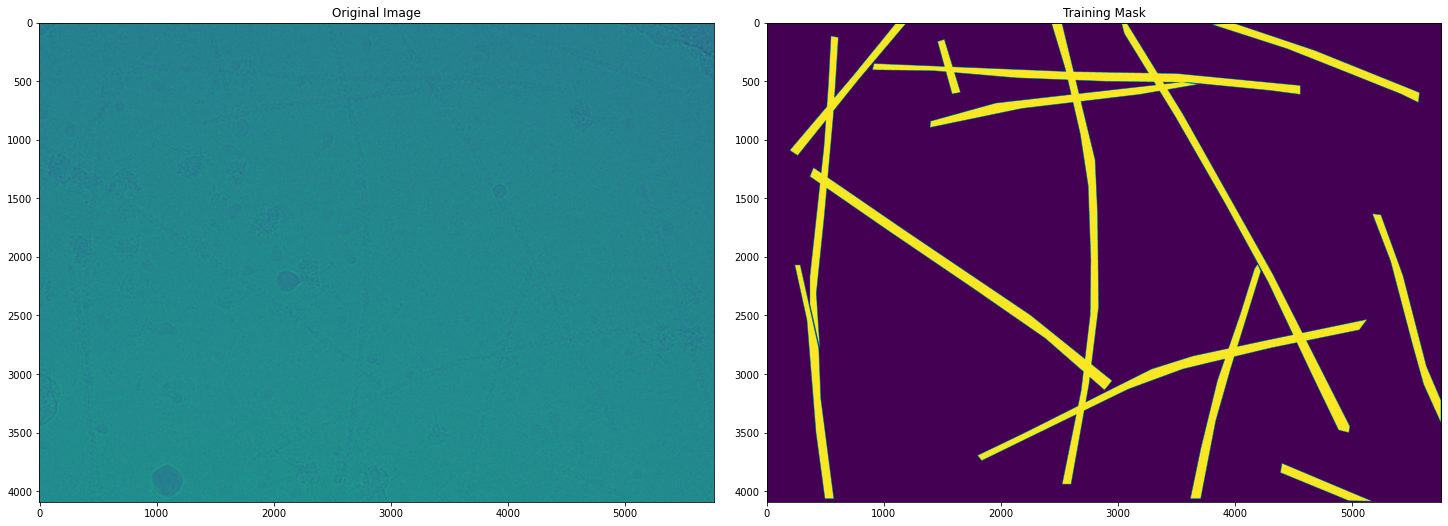

In [ ]:
# Display resized image and mask
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 10))
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[1].imshow(original_mask)
ax[1].set_title('Training Mask')
plt.show()
fig.savefig(os.path.join(fig_dir, 'original-data.png'))

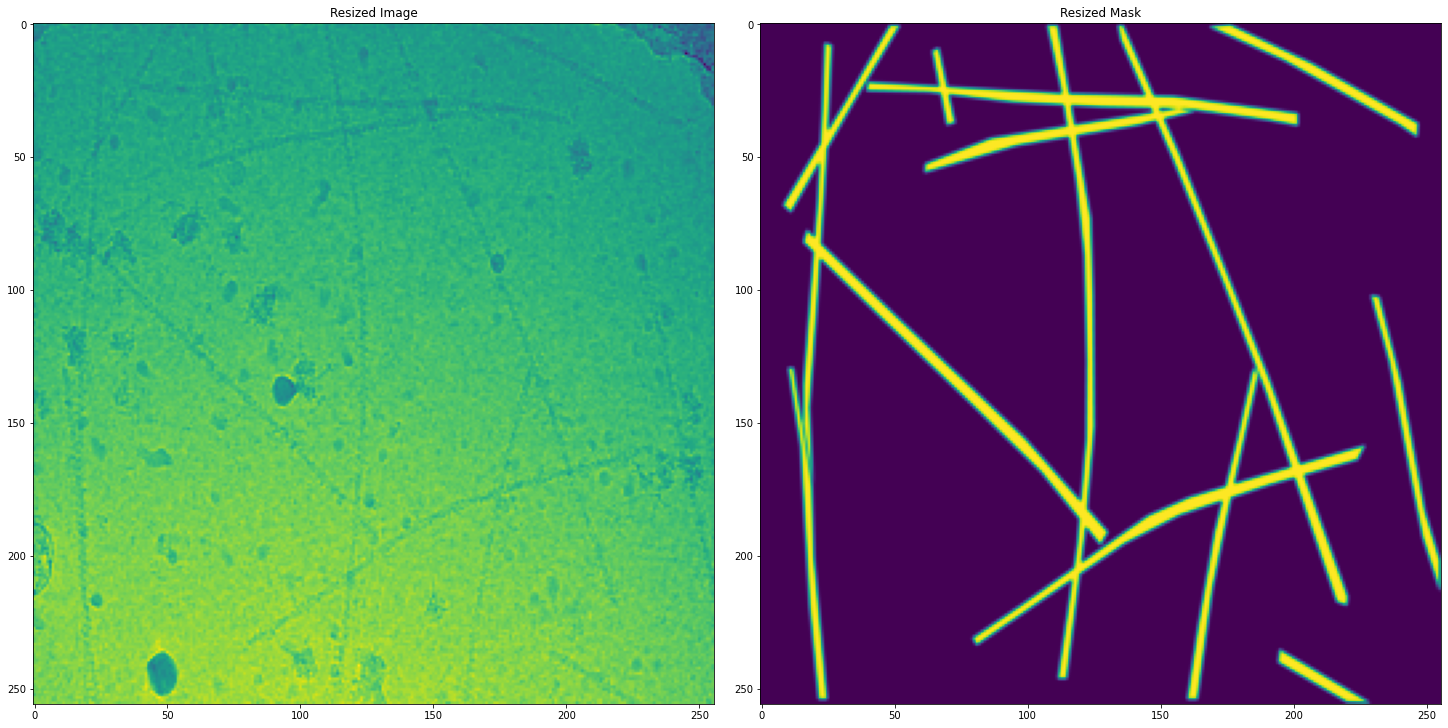

In [ ]:
# Display resized image and mask
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 10))
ax[0].imshow(resized_image[0, :, :, 0])
ax[0].set_title('Resized Image')
ax[1].imshow(resized_mask)
ax[1].set_title('Resized Mask')
plt.show()
fig.savefig(os.path.join(fig_dir, 'original-resized.png'))

## Semantic segmentation prediction

Instantiate model and load the `best-weights.h5` from previous training sessions.

In [ ]:
from models import Autoencoder

# Instantiate model
model = Autoencoder()

# Call model to build and initialise weights
model(resized_image)

if os.path.exists(best_weights_path):
    model.load_weights(best_weights_path)
    print('Model loaded with previous `best weights`.')
else:
    print('No weights loaded: random initialisation.')

Model loaded with previous `best weights`.


Generate prediction mask.

In [ ]:
# Execute prediciton
raw_prediction = np.squeeze(model(resized_image))

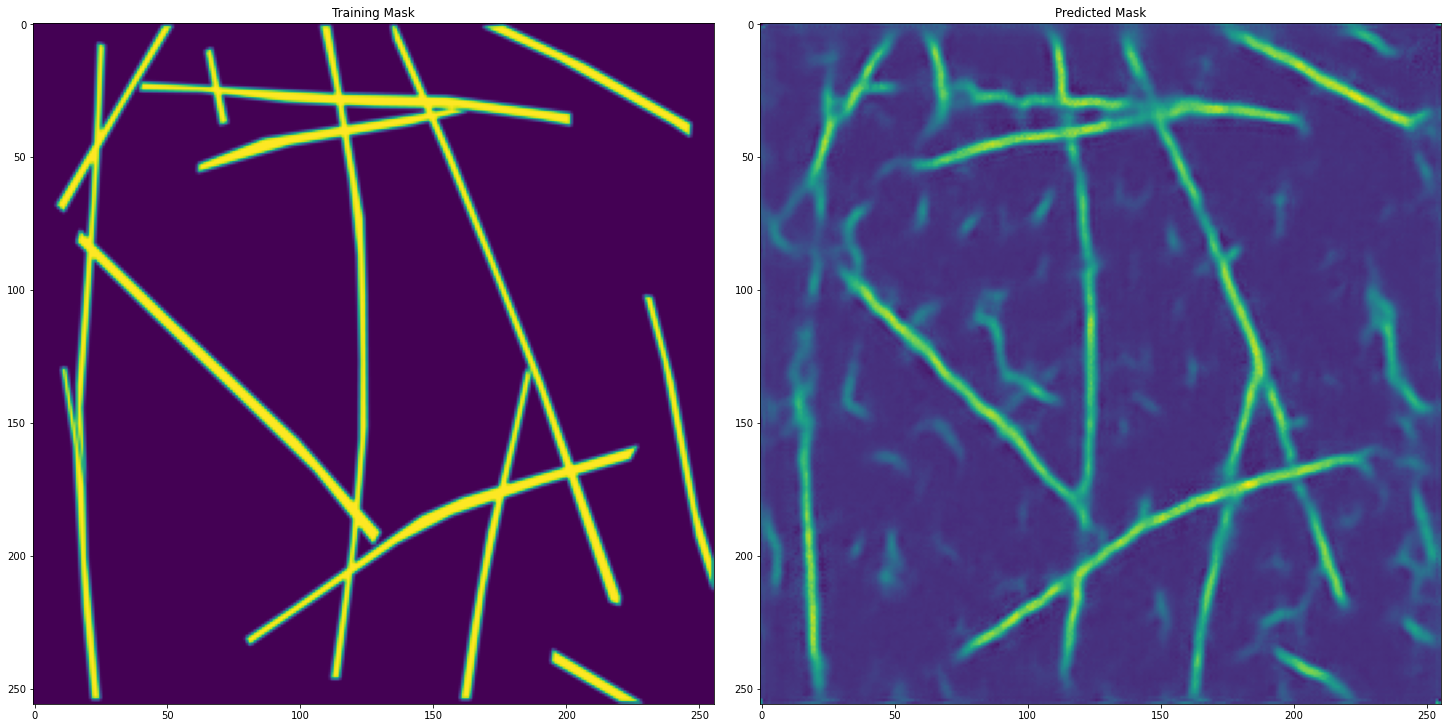

In [ ]:
# Display output prediction vs. GT
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(20,10))
ax[1].imshow(raw_prediction)
ax[1].set_title('Predicted Mask')
ax[0].imshow(resized_mask)
ax[0].set_title('Training Mask')
plt.show()
fig.savefig(os.path.join(fig_dir, 'prediction-raw.png'))

Upscale to binary mask.

In [ ]:
threshold = 0.4

# Prediciton
pred_mask = raw_prediction.copy()

# Resize prediction mask relative to original image
pred_mask = transform.resize(pred_mask, original_size, anti_aliasing=False)

# Normalise mask values over [0, 1]
min_val = np.min(pred_mask)
max_val = np.max(pred_mask)
pred_mask = (pred_mask - min_val) / (max_val - min_val)

# Apply threshold
pred_mask = (pred_mask > threshold).astype(np.uint8)

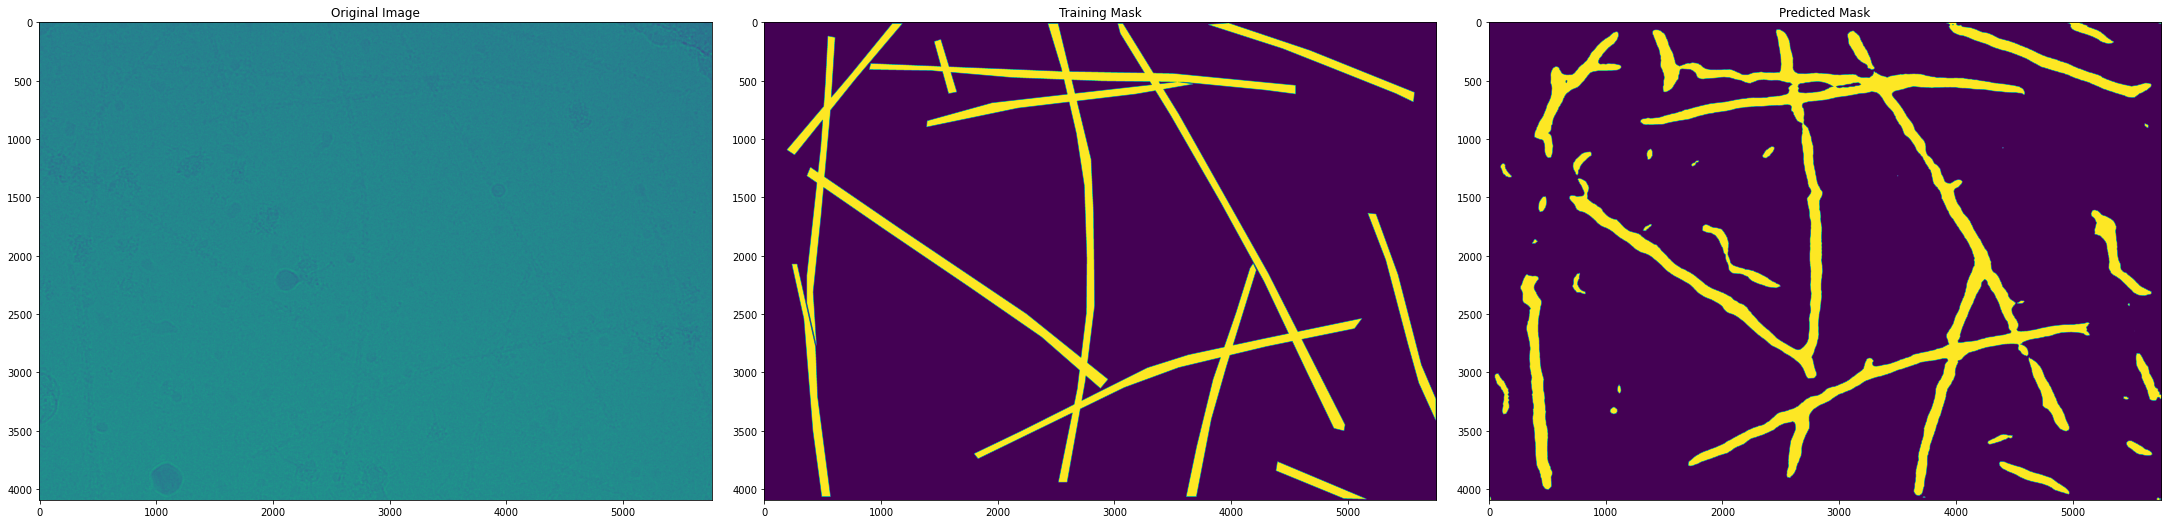

In [ ]:
# Display resized image and mask
fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(30,10))
ax[2].imshow(pred_mask)
ax[2].set_title('Predicted Mask')
ax[1].imshow(original_mask)
ax[1].set_title('Training Mask')
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
plt.show()
fig.savefig(os.path.join(fig_dir, 'prediction-binary.png'))

## Instance segmentation extraction

Set hyperparameters

In [ ]:
# Minimum line length to extract as proportion of longest image length
length_tol = 0.15

# Proposed pixel width of filaments
line_pixel_width = 130

# Pixel seperation between proposed lines: less -> more lines
line_sep = line_pixel_width

Perform line extraction.

In [ ]:
# Compute instances and line ends from semantic mask
from utils import get_line_instances

instances, line_ends = get_line_instances(
    pred_mask, length_tol, line_pixel_width, line_sep,
    )

### Save Coordinates

In [ ]:
%%capture cap_params --no-stderr
print('Hyperparameters:')
print('----------------\n')
print('length_tol = ', length_tol)
print('line_pixel_width = ', line_pixel_width)
print('line_sep = ', line_sep)

In [ ]:
# Save params to text file
with open(os.path.join(fig_dir, 'params.txt'), 'w') as f:
    f.write(str(cap_params))

In [ ]:
%%capture cap_coords --no-stderr
print('Line ending pixel coords pixel (row, col)')
print('-----------------------------------------\n')
print('Image filename: ', os.path.basename(image_path))
print('Number of filaments with colinear portions identified: ', len(instances))

# Check line ends
for idx, end_pairs in enumerate(line_ends):
    print('\nLine endings on filament {}:'.format(idx+1))
    for ends in end_pairs:
        e1 = ends[0]
        e2 = ends[1]
        print('({e1y:d}, {e1x:d}) -> ({e2y:d}, {e2x:d})'.format(
            e1y=int(e1[0]), e1x=int(e1[1]), e2y=int(e2[0]), e2x=int(e2[1])
        ))

In [ ]:
# Save coordinates to text file
with open(os.path.join(fig_dir, 'coords.txt'), 'w') as f:
    f.write(str(cap_coords))

In [ ]:
from utils import coords2star

# Save coordinates to STAR file
star_dir = os.path.join(fig_dir, 'coords.star')
coords2star(star_dir)

In [ ]:
# Print output
print(str(cap_coords))

Line ending pixel coords pixel (row, col)
-----------------------------------------

Image filename:  tf2_027.png
Number of co-linear filaments identified:  11

Line endings on line 1:
(448, 3337) -> (1257, 3768)
(1286, 3783) -> (2750, 4562)

Line endings on line 2:
(434, 1767) -> (555, 4540)

Line endings on line 3:
(597, 3266) -> (728, 2196)
(729, 2193) -> (838, 1301)

Line endings on line 4:
(1486, 702) -> (3012, 2803)

Line endings on line 5:
(2841, 3656) -> (3798, 1736)

Line endings on line 6:
(480, 4060) -> (495, 2376)

Line endings on line 7:
(1871, 4209) -> (4051, 3665)

Line endings on line 8:
(1557, 2827) -> (3023, 2712)

Line endings on line 9:
(2579, 5137) -> (3049, 3100)

Line endings on line 10:
(2644, 4525) -> (2911, 3702)
(2918, 3681) -> (3234, 2709)

Line endings on line 11:
(2163, 329) -> (4002, 506)



### Plot instance segmentation.

In [ ]:
%matplotlib inline

In [ ]:
print('Graphical output for image:', os.path.basename(image_path))

Graphical output for image: tf2_027.png


Original image overlayed with instance masks.

/content/gdrive/MyDrive/IDSAI/PROOF/filament-segmentation/utils/instance_vis.py:40: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  kind='overlay',


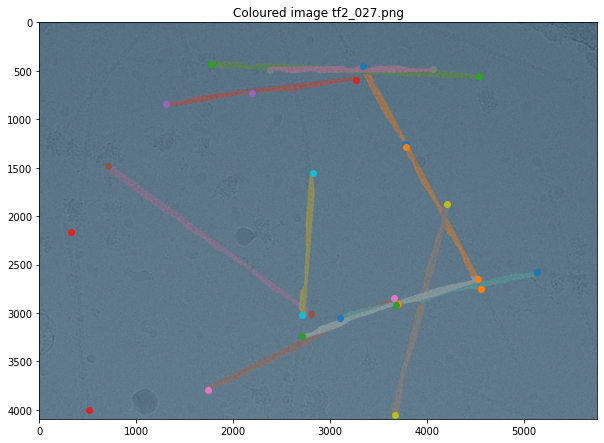

In [ ]:
from utils import shade_instances

# Plot shaded view of instances
fig = shade_instances(
    os.path.basename(image_path), original_image, instances, line_ends
    )

Semantic mask overlayed with instance masks.

/content/gdrive/MyDrive/IDSAI/PROOF/filament-segmentation/utils/instance_vis.py:40: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  kind='overlay',


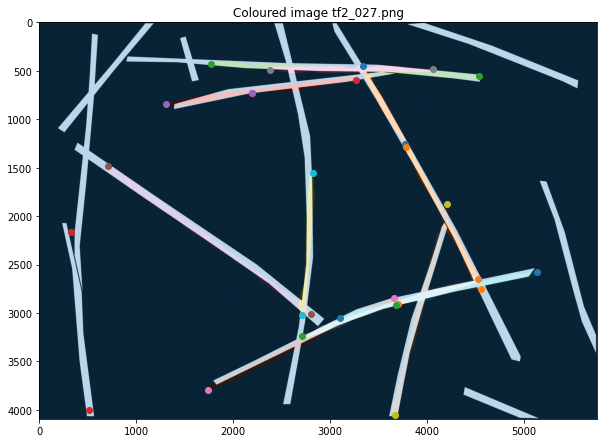

In [ ]:
# Plot grid view of instances
fig = shade_instances(
    os.path.basename(image_path), original_mask, instances, line_ends
    )

Grid view of instances.

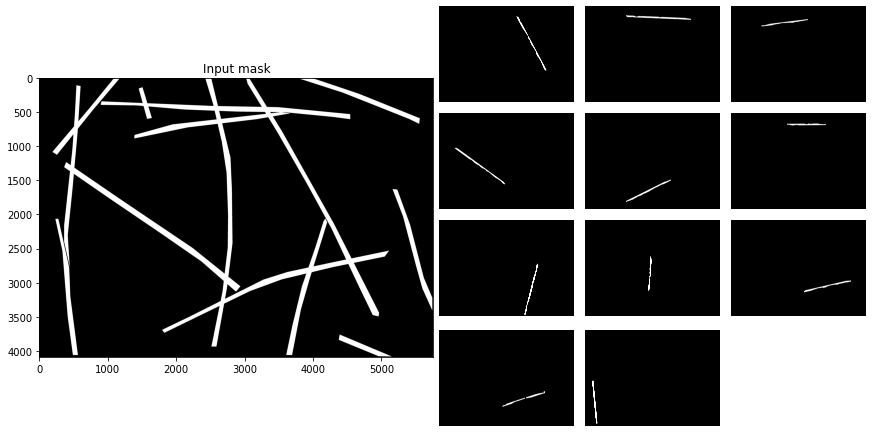

In [ ]:
from utils import grid_display_masks

# Plot grid view of instances
fig = grid_display_masks(image_path, original_mask, instances)

Save all figures.

/content/gdrive/MyDrive/IDSAI/PROOF/filament-segmentation/utils/instance_vis.py:40: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  kind='overlay',


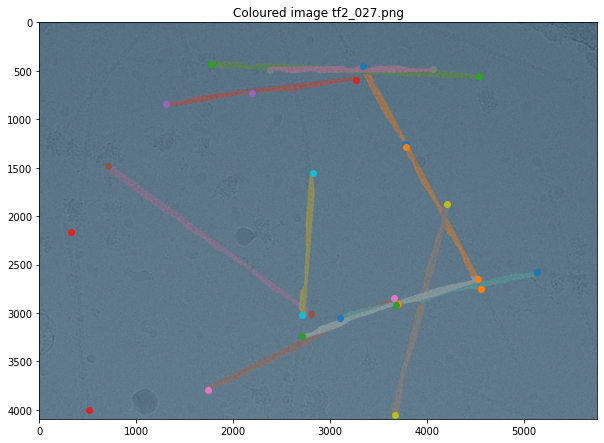

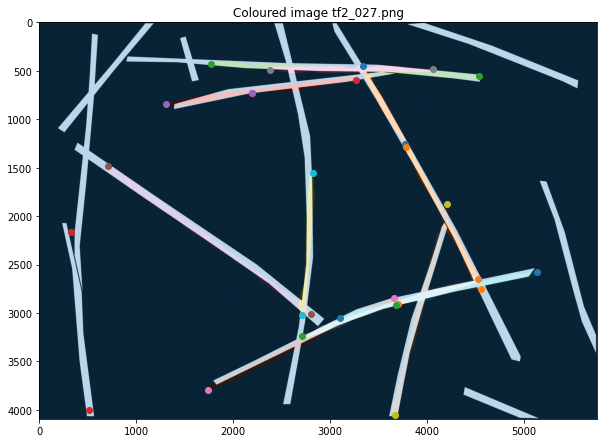

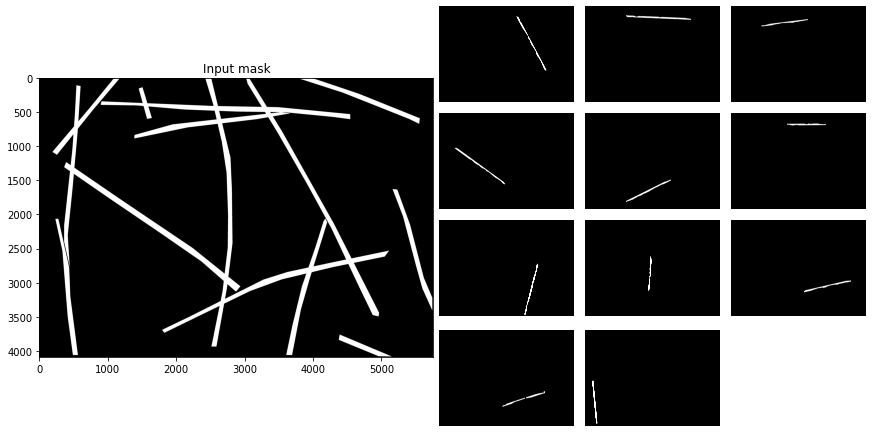

In [ ]:
fig1 = shade_instances(image_file, original_image, instances, line_ends)

fig2 = shade_instances(image_file, original_mask, instances, line_ends)

fig3 = grid_display_masks(image_file, original_mask, instances)

fig1.savefig(os.path.join(fig_dir, 'instance1.png'))
fig2.savefig(os.path.join(fig_dir, 'instance2.png'))
fig3.savefig(os.path.join(fig_dir, 'instance3.png'))